In [1]:
#Imports
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, Flatten, Dense, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import numpy as np

from imutils import paths
import shutil
import sys, random, os

In [2]:
# #if using GPU, set the correct GPU and assign memory growth
# tf.compat.v1.reset_default_graph()
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [3]:
#Obtain the dataset from https://www.kaggle.com/nabeelsajid917/covid-19-x-ray-10000-images/data, 
# and place the outputted "generated_dataset" into the folder with this ipynb file

#obtain the file directory using pwd
my_data_dir = os.getcwd()

#set file path for Covid images and normal images
all_covid  = os.path.join(my_data_dir, 'generated_dataset','covid')
all_normal = os.path.join(my_data_dir, 'generated_dataset', 'normal')

#Obtain relative file paths for each image 
imagePathsCovid = list(paths.list_images(all_covid))
imagePathsNormal = list(paths.list_images(all_normal))

#set file path for new test and train covid data
pathCovidTest = os.path.join(my_data_dir, 'test', 'covid')
pathCovidTrain = os.path.join(my_data_dir, 'train', 'covid')

#set file path for new test and train normal data
pathNormalTest = os.path.join(my_data_dir, 'test', 'normal')
pathNormalTrain = os.path.join(my_data_dir, 'train', 'normal')

In [4]:
#function for shuffling and randomly splitting files into selected directories, with specified ratio 
def splitdirs(files, dir1, dir2, ratio):
    shuffled = files[:]
    random.shuffle(shuffled)
    num = round(len(shuffled) * ratio)
    to_dir1, to_dir2 = shuffled[:num], shuffled[num:]
    for d in dir1, dir2:
        if not os.path.isdir(d):
            os.makedirs(d)
    for file in to_dir1:
        shutil.copyfile(file, os.path.join(dir1, os.path.basename(file)))
    for file in to_dir2:
        shutil.copyfile(file, os.path.join(dir2, os.path.basename(file)))

In [5]:
#set ratio for splitting
ratio = 0.25
ratio = float(ratio)
      
#call functions for splitting data
splitdirs(imagePathsCovid, pathCovidTest, pathCovidTrain, ratio)
splitdirs(imagePathsNormal, pathNormalTest, pathNormalTrain, ratio)

In [6]:
#check folder directory
os.listdir(my_data_dir) 

['.git',
 '.ipynb_checkpoints',
 'COVIDXNet.ipynb',
 'Example Model',
 'generated_dataset',
 'README.md',
 'requirements.txt',
 'test',
 'train']

In [7]:
#assign new paths for test and train paths
test_path = os.path.join(my_data_dir, 'test')
train_path = os.path.join(my_data_dir, 'train')

In [8]:
#check paths are working
os.listdir(test_path)

['covid', 'normal']

In [9]:
#check paths are working
os.listdir(train_path)

['covid', 'normal']

In [10]:
#obtain filepath for single covid scan
covid_scan = os.path.join(pathCovidTrain, os.listdir(pathCovidTrain)[0])

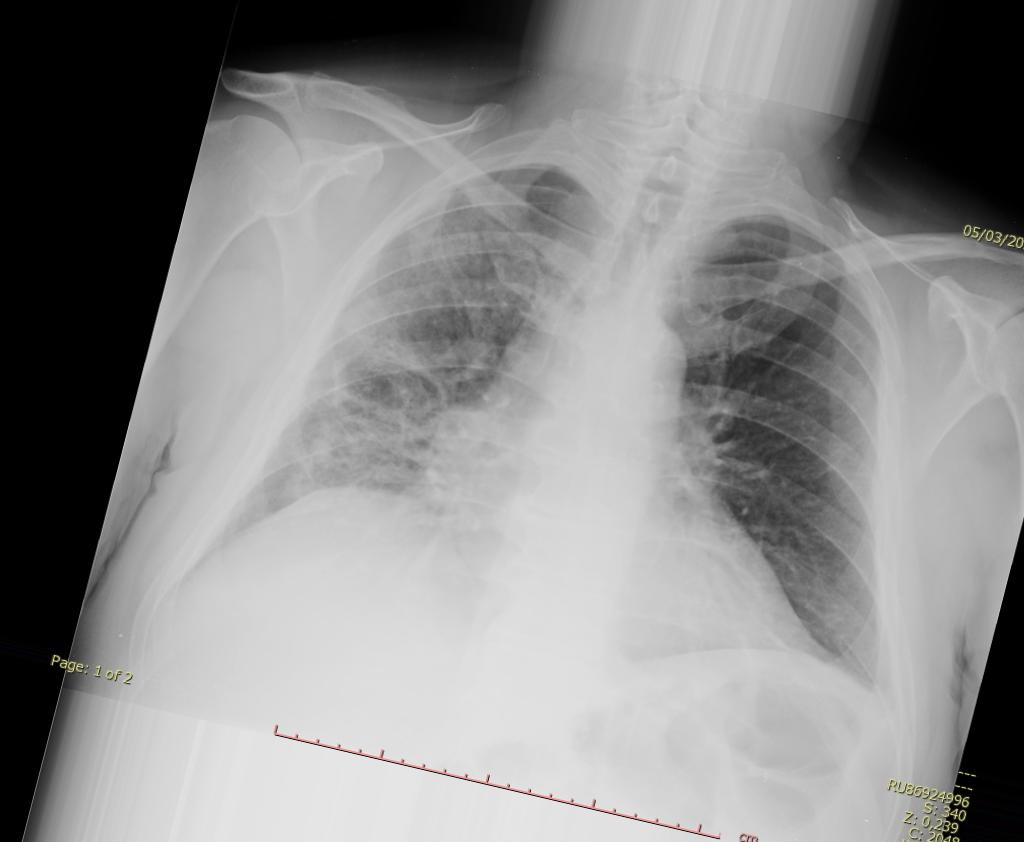

In [11]:
#check single image
my_image = image.load_img(covid_scan)
my_image

In [12]:
image_shape = (512,512,3)

In [13]:
#Create a new image generator, amending and reshaping the data as described
image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # AlloW horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

In [14]:
#check image gen for train path
image_gen.flow_from_directory(train_path)

Found 5640 images belonging to 2 classes.


In [15]:
#check image gen for test path
image_gen.flow_from_directory(test_path)

Found 1880 images belonging to 2 classes.


In [16]:
#Create Model
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(4, 4)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(4, 4)))

model.add(Conv2D(filters=128, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(4, 4)))

model.add(Flatten())

model.add(Dense(128))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [17]:
#check summary of model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 510, 510, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0

In [18]:
#Create early stopping callback
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [19]:
batch_size = 16
epochs = 20

In [20]:
#Create training image generator
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                                color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary')

Found 5640 images belonging to 2 classes.


In [21]:
#Create testing image generator
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary',shuffle=False)

Found 1880 images belonging to 2 classes.


In [22]:
#train the model
model.fit(train_image_gen,epochs=epochs,
          validation_data=test_image_gen,
           callbacks=[early_stop])

Epoch 1/20
353/353 [==============================] - 312s 883ms/step - loss: 0.3263 - accuracy: 0.8594 - val_loss: 0.1725 - val_accuracy: 0.9223
Epoch 2/20
353/353 [==============================] - 286s 809ms/step - loss: 0.1776 - accuracy: 0.9245 - val_loss: 0.0911 - val_accuracy: 0.9553
Epoch 3/20
353/353 [==============================] - 288s 816ms/step - loss: 0.1117 - accuracy: 0.9525 - val_loss: 0.0533 - val_accuracy: 0.9782
Epoch 4/20
353/353 [==============================] - 285s 807ms/step - loss: 0.0652 - accuracy: 0.9780 - val_loss: 0.0230 - val_accuracy: 0.9931
Epoch 5/20
353/353 [==============================] - 285s 806ms/step - loss: 0.0319 - accuracy: 0.9890 - val_loss: 0.0115 - val_accuracy: 0.9973
Epoch 6/20
353/353 [==============================] - 285s 806ms/step - loss: 0.0283 - accuracy: 0.9894 - val_loss: 0.0199 - val_accuracy: 0.9910
Epoch 7/20
353/353 [==============================] - 286s 809ms/step - loss: 0.0227 - accuracy: 0.9929 - val_loss: 0.0302 -

In [23]:
#save the model
model.save('covid_detector.h5')

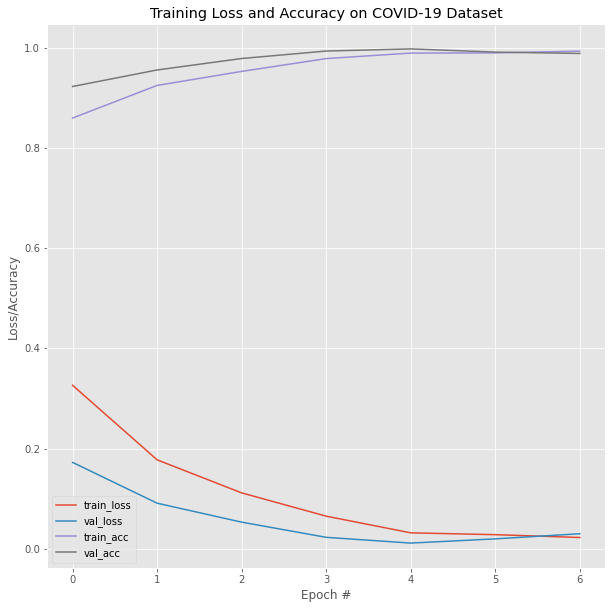

In [24]:
#Produce Graph showing training information
N = epochs
plt.style.use("ggplot")
plt.figure(figsize=(10,10))
plt.plot(model.history.history["loss"], label="train_loss")
plt.plot(model.history.history["val_loss"], label="val_loss")
plt.plot(model.history.history["accuracy"], label="train_acc")
plt.plot(model.history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [25]:
#Pass the test image generator through the model to obtain prediction probabilities
pred_probabilities = model.predict(test_image_gen)

In [26]:
#Split the predictions based on confidence
predictions = pred_probabilities > 0.5

In [27]:
print(classification_report(test_image_gen.classes,predictions, target_names=train_image_gen.class_indices))

              precision    recall  f1-score   support

       covid       1.00      0.98      0.99      1269
      normal       0.96      1.00      0.98       611

    accuracy                           0.99      1880
   macro avg       0.98      0.99      0.99      1880
weighted avg       0.99      0.99      0.99      1880



In [28]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(test_image_gen.classes, predictions)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[1246   23]
 [   0  611]]
acc: 0.9878
sensitivity: 0.9819
specificity: 1.0000


In [ ]:
# #if using a seperate image, reassign covid_scan to different filepath
# covid_scan = #filepath#

In [29]:
#Load initial sample image to test 
my_image = image.load_img(covid_scan,target_size=image_shape)
#conver the image to array
my_image = image.img_to_array(my_image)
#expand the dimensions
my_image = np.expand_dims(my_image, axis=0)
#scale the image
my_image = my_image/255

In [36]:
#predict the image 
int(round(model.predict(my_image)[0][0]))

0

In [37]:
#See class indeces of training generator
train_image_gen.class_indices

{'covid': 0, 'normal': 1}